### Telkomathon Clustering Assignment

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage

##### Importing Data

In [2]:
df = pd.read_csv('data/transactions.csv')
df.head(5)

customer_id trans_date  trans_amount
0      CS5295  11-Feb-18            35
1      CS4768  15-Mar-20            39
2      CS2122  26-Feb-18            52
3      CS1217  16-Nov-16            99
4      CS1850  20-Nov-18            78

In [3]:
df.shape

(125000, 3)

In [4]:
df.dtypes

customer_id     object
trans_date      object
trans_amount     int64
dtype: object

##### Number of Customer Id

In [5]:
df['customer_id'].drop_duplicates().count()

6889

##### Change invalid date and change string to date datatype

In [6]:
df.isnull().sum()

customer_id     0
trans_date      0
trans_amount    0
dtype: int64

In [7]:
df['trans_date'] = df['trans_date'].replace('29-Feb-17','28-Feb-17')

In [8]:
df['trans_date'] = df['trans_date'].astype('datetime64[ns]')

In [9]:
df.dtypes

customer_id             object
trans_date      datetime64[ns]
trans_amount             int64
dtype: object

In [10]:
df.head()

customer_id trans_date  trans_amount
0      CS5295 2018-02-11            35
1      CS4768 2020-03-15            39
2      CS2122 2018-02-26            52
3      CS1217 2016-11-16            99
4      CS1850 2018-11-20            78

##### Checking Customer status, contain new or not

In [11]:
check = df.groupby(['customer_id']).min()

In [12]:
last_trans = df['trans_date'].max()
last_trans

Timestamp('2020-03-16 00:00:00')

In [13]:
import datetime as dt

check['long_cust'] = last_trans-check['trans_date']
check['long_cust'] = check['long_cust'].astype(str).str.split(expand=True)
check['long_cust'] = check['long_cust'].astype(int)
check.describe()

trans_amount    long_cust
count   6889.000000  6889.000000
mean      31.709682  1321.458122
std       11.202856    84.539087
min       10.000000   507.000000
25%       22.000000  1294.000000
50%       36.000000  1347.000000
75%       38.000000  1380.000000
max       66.000000  1400.000000

In [14]:
check.head()

trans_date  trans_amount  long_cust
customer_id                                    
CS1112      2016-06-15            36       1370
CS1113      2016-05-27            36       1389
CS1114      2016-07-14            37       1341
CS1115      2016-08-10            41       1314
CS1116      2016-06-27            40       1358

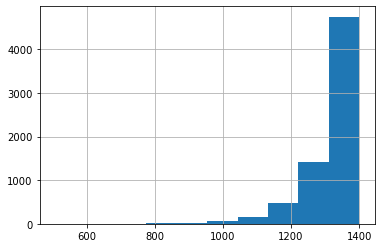

In [15]:
check['long_cust'].hist()
plt.show()

From histogram we can see that most of customer is not new customer

#### Recency, Frequency, Monetary

Create Table based on Customer ID

In [16]:
df_cust = df.loc[:,['customer_id']].drop_duplicates().sort_values(by=['customer_id'])
df_cust = df_cust.set_index(df_cust['customer_id'].values)
df_cust.head()

customer_id
CS1112      CS1112
CS1113      CS1113
CS1114      CS1114
CS1115      CS1115
CS1116      CS1116

##### Get Recency Information from Transaction Date

In [17]:
df['recency'] = dt.datetime(2020,8,17) - df['trans_date']
df['recency'] = df['recency'].astype(str).str.split(expand=True)
df['recency'] = df['recency'].astype(int)
df.head(5)

customer_id trans_date  trans_amount  recency
0      CS5295 2018-02-11            35      918
1      CS4768 2020-03-15            39      155
2      CS2122 2018-02-26            52      903
3      CS1217 2016-11-16            99     1370
4      CS1850 2018-11-20            78      636

In [18]:
df_cust['recency'] = df.groupby(['customer_id']).min().drop(['trans_date','trans_amount'],axis=1)
df_cust.head(5)

customer_id  recency
CS1112      CS1112      216
CS1113      CS1113      190
CS1114      CS1114      187
CS1115      CS1115      165
CS1116      CS1116      358

##### Get Frequency Information

1. Frequency from first to last transaction

In [19]:
df_cust['frequency'] = df.groupby(['customer_id']).count().drop(['trans_amount','recency'],axis=1)
df_cust.head(5)

customer_id  recency  frequency
CS1112      CS1112      216         15
CS1113      CS1113      190         20
CS1114      CS1114      187         19
CS1115      CS1115      165         22
CS1116      CS1116      358         13

1.a Checking Average range of transaction from each customer

In [20]:
check['range_trans'] = check['long_cust']/df_cust['frequency']
check.head()

trans_date  trans_amount  long_cust  range_trans
customer_id                                                 
CS1112      2016-06-15            36       1370    91.333333
CS1113      2016-05-27            36       1389    69.450000
CS1114      2016-07-14            37       1341    70.578947
CS1115      2016-08-10            41       1314    59.727273
CS1116      2016-06-27            40       1358   104.461538

In [21]:
check[['range_trans']].describe()

range_trans
count  6889.000000
mean     79.846120
std      27.850693
min      35.666667
25%      61.454545
50%      73.105263
75%      90.600000
max     326.250000

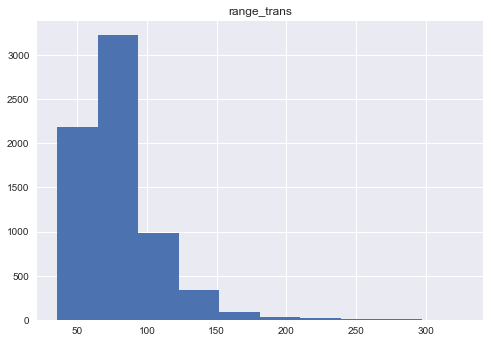

In [59]:
check[['range_trans']].hist()
plt.show()

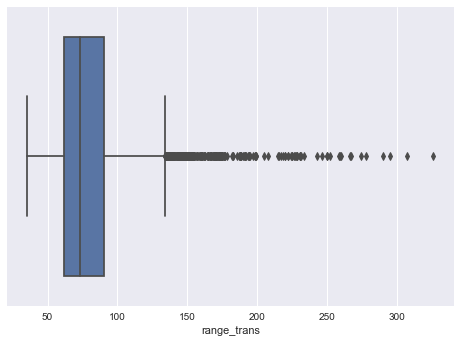

In [60]:
ax = sns.boxplot(x="range_trans", data=check)

From above information, we can see that most of average transaction is in range 61 to 90 days

##### Get Monetary Information

1. Total Amount first to last transaction

In [22]:
df_cust['monetary'] = df.groupby(['customer_id']).sum().drop(['recency'],axis=1)
df_cust.head()

customer_id  recency  frequency  monetary
CS1112      CS1112      216         15      1012
CS1113      CS1113      190         20      1490
CS1114      CS1114      187         19      1432
CS1115      CS1115      165         22      1659
CS1116      CS1116      358         13       857

In [23]:
df_cust = df_cust.reset_index(drop=True)
df_cust.head()

customer_id  recency  frequency  monetary
0      CS1112      216         15      1012
1      CS1113      190         20      1490
2      CS1114      187         19      1432
3      CS1115      165         22      1659
4      CS1116      358         13       857

In [24]:
df_cust.describe()

recency    frequency     monetary
count  6889.000000  6889.000000  6889.000000
mean    235.349252    18.144869  1179.269705
std      85.545443     5.193014   465.832609
min     154.000000     4.000000   149.000000
25%     177.000000    14.000000   781.000000
50%     208.000000    18.000000  1227.000000
75%     266.000000    22.000000  1520.000000
max    1012.000000    39.000000  2933.000000

In [61]:
check2 = df_cust['monetary']/df_cust['frequency']
check2.head()

0    67.466667
1    62.611111
2    72.875000
3    64.388889
4    70.750000
dtype: float64

In [62]:
check2.describe()

count    6889.000000
mean       63.086561
std        12.426638
min        26.700000
25%        52.666667
50%        67.700000
75%        72.000000
max        87.400000
dtype: float64

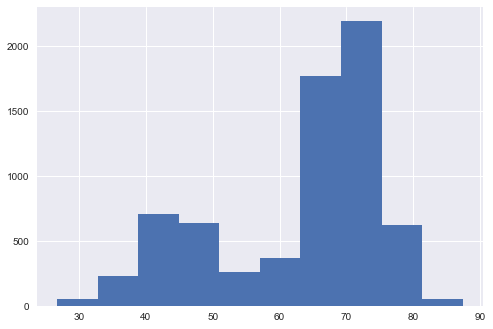

In [63]:
check2.hist()
plt.show()

### Data Visualization

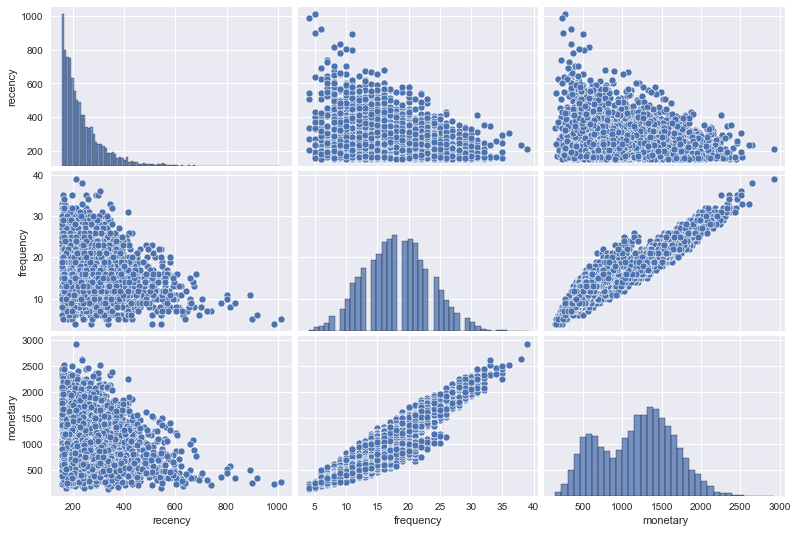

In [25]:
plt.style.use('seaborn')
sns.pairplot(df_cust.drop(['customer_id'],axis=1), aspect=1.5)
plt.show()

C:\Users\ariya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ariya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ariya\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

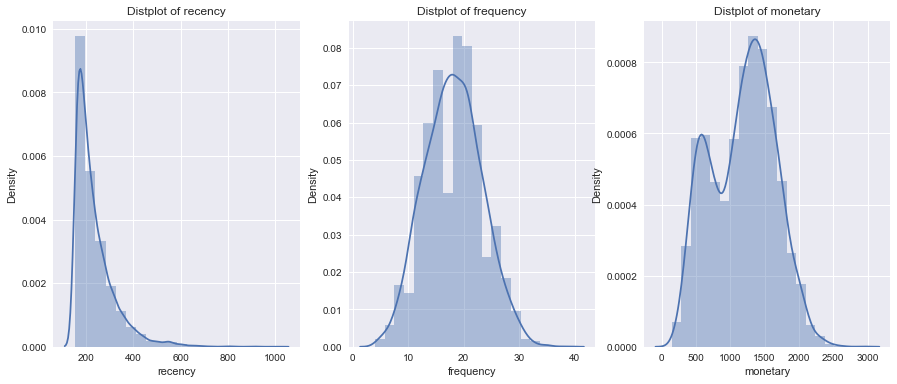

In [26]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['recency' , 'frequency' , 'monetary']:
    n += 1
    plt.subplot(1 , 3 , n)
    sns.distplot(df_cust[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

From this distribution plot and data description above, we conclude that :
1. In recency, since the minimum is 154 days and we know that Q1 = 177 days(< 1 month), Q2 =208 days(<2 month), and Q3 = 266 days (nearly 4 month) and we also know that range of average transaction 35 days to ~140 days, so we can consider that recency > 300 days is inactive user
2. In frequency, we can assume that customer with small frequency is not because they are new customer
3. In monetray, small amount in transaction is affect of small frequency, we can see that range Q1 and Q3 from average amount transaction in 53 and 72

### Standardized Variable

In [27]:
X = df_cust.drop(['customer_id'], axis=1)
XR = pd.DataFrame(X['recency'])
XF = pd.DataFrame(X['frequency'])
XM = pd.DataFrame(X['monetary'])

standardize = StandardScaler()
X_std = pd.DataFrame(standardize.fit_transform(X))
X_std.columns = X.columns

## MODELING

### K-Means

In [28]:
def k_means_inertia_silhouette(X, k_max = 10, init = 'k-means++'):
    inertia = []
    silhouette = []
    for k in range(2, k_max):
        km =  KMeans(init = init, n_clusters = k, random_state= 123)
        km.fit(X)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia')
    plt.show()

    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score')
    plt.show()
    
    return inertia, silhouette

#### 1. Working with each variable

1.a. Recency

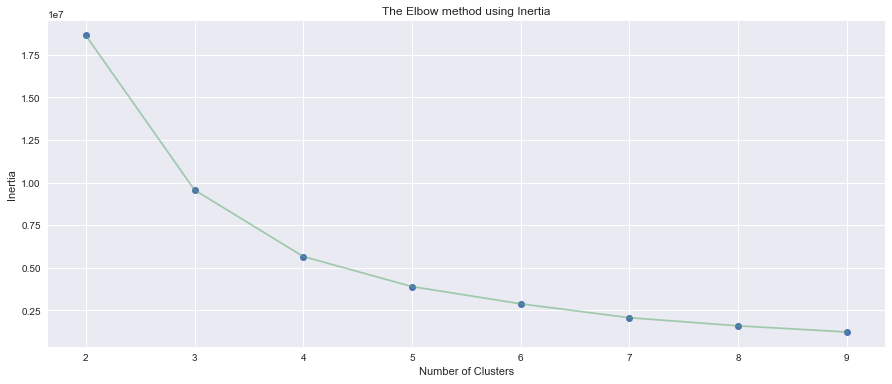

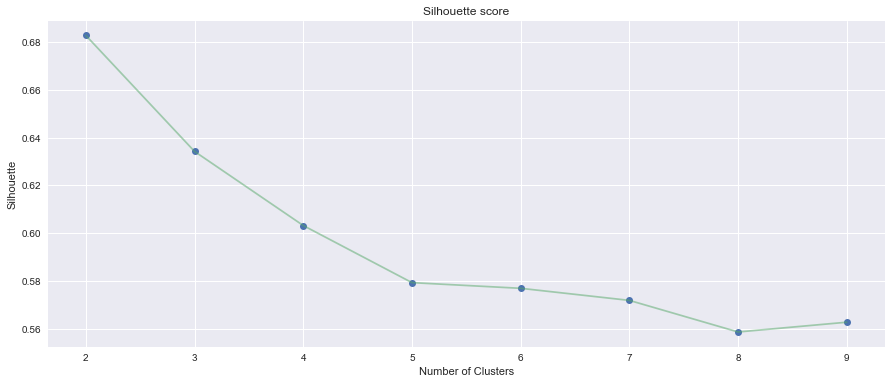

In [29]:
inertia, silhouette = k_means_inertia_silhouette(XR, k_max = 10, init = 'k-means++')

We choose k=4 due to elbow from inertia indicates 4, and in silhouette decrease not quite significant

In [30]:
k = 4
k_meansR = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_meansR.fit(XR)

KMeans(n_clusters=4, random_state=123)

In [31]:
SegmentR = k_meansR.labels_
XR.groupby(SegmentR, as_index=False).mean().sort_values(by='recency',ignore_index=True)

recency
0  180.168740
1  251.404093
2  357.846323
3  563.458101

In [32]:
df_cust['R'] = k_meansR.predict(df_cust[['recency']])
df_cust.head()

customer_id  recency  frequency  monetary  R
0      CS1112      216         15      1012  2
1      CS1113      190         20      1490  1
2      CS1114      187         19      1432  1
3      CS1115      165         22      1659  1
4      CS1116      358         13       857  3

##### Function to Order Cluster number

In [33]:
def cluster_order(cluster_column,target_column,df,order):
    df_label = df.groupby([cluster_column])[target_column].mean().reset_index()
    df_label = df_label.sort_values(by=target_column,ascending=order).reset_index(drop=True)
    df_label['dummy'] = df_label.index
    df_dummy = pd.merge(df,df_label[[cluster_column,'dummy']],on=cluster_column)
    df_dummy = df_dummy.drop([cluster_column],axis=1)
    df_dummy = df_dummy.rename(columns={'dummy':cluster_column})
    return df_dummy

In [34]:
df_cust = cluster_order('R','recency',df_cust,False)
df_cust.head()

customer_id  recency  frequency  monetary  R
0      CS1112      216         15      1012  2
1      CS1123      264         19      1331  2
2      CS1124      228         18      1127  2
3      CS1128      230         26      1921  2
4      CS1129      261         12       853  2

In [35]:
df_cust.groupby(['R'])['recency'].describe()

count        mean        std    min    25%    50%    75%     max
R                                                                   
0   179.0  563.458101  98.153698  462.0  498.5  543.0  593.5  1012.0
1   911.0  357.846323  41.147984  305.0  322.0  349.0  387.0   459.0
2  2101.0  251.404093  24.722536  216.0  229.0  248.0  271.0   304.0
3  3698.0  180.168740  17.447744  154.0  165.0  179.0  194.0   215.0

1.a. Frequency

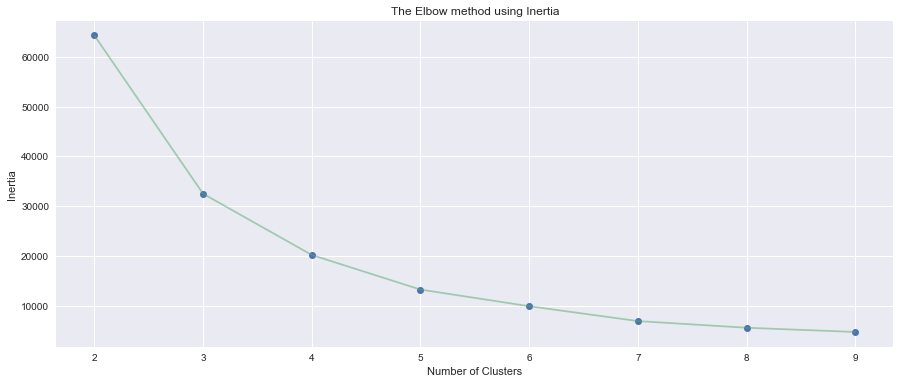

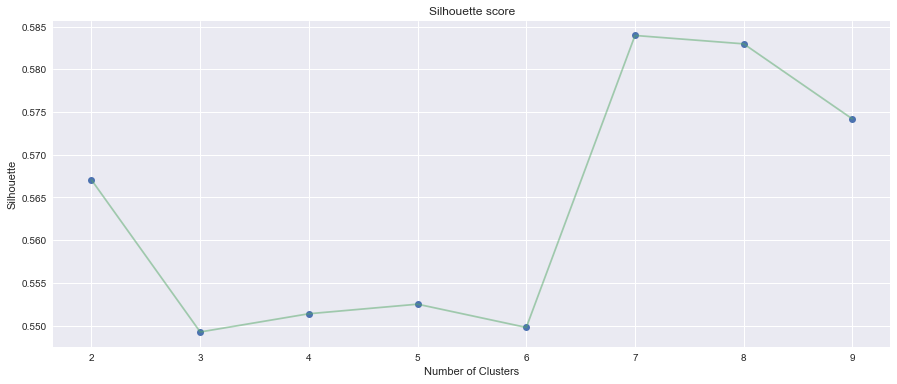

In [36]:
inertia, silhouette = k_means_inertia_silhouette(XF, k_max = 10, init = 'k-means++')

We choose k=4 due to elbow from inertia indicates 4, and in silhouette decrease not quite significant

In [37]:
k = 4
k_meansF = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_meansF.fit(XF)

KMeans(n_clusters=4, random_state=123)

In [38]:
SegmentF = k_meansF.labels_
XF.groupby(SegmentF, as_index=False).mean().sort_values(by='frequency',ignore_index=True)

frequency
0  11.565118
1  17.075732
2  21.717975
3  27.065301

In [39]:
df_cust['F'] = k_meansF.predict(df_cust[['frequency']])
df_cust.head()

customer_id  recency  frequency  monetary  R  F
0      CS1112      216         15      1012  2  0
1      CS1123      264         19      1331  2  0
2      CS1124      228         18      1127  2  0
3      CS1128      230         26      1921  2  1
4      CS1129      261         12       853  2  2

In [40]:
df_cust = cluster_order('F','frequency',df_cust,True)
df_cust.head()

customer_id  recency  frequency  monetary  R  F
0      CS1112      216         15      1012  2  1
1      CS1123      264         19      1331  2  1
2      CS1124      228         18      1127  2  1
3      CS1134      264         16      1166  2  1
4      CS1139      266         18      1245  2  1

In [41]:
df_cust.groupby(['F'])['frequency'].describe()

count       mean       std   min   25%   50%   75%   max
F                                                           
0  1743.0  11.565118  2.182326   4.0  10.0  12.0  13.0  14.0
1  2390.0  17.075732  1.384796  15.0  16.0  17.0  18.0  19.0
2  1975.0  21.717975  1.384879  20.0  20.0  22.0  23.0  24.0
3   781.0  27.065301  2.128461  25.0  25.0  27.0  28.0  39.0

1.a. Monetary

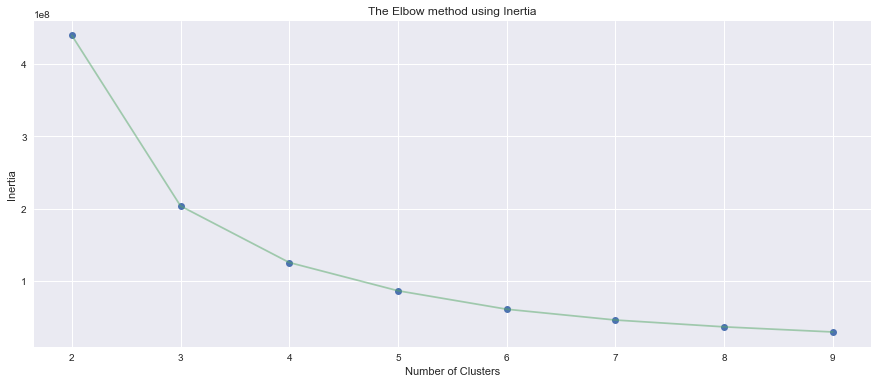

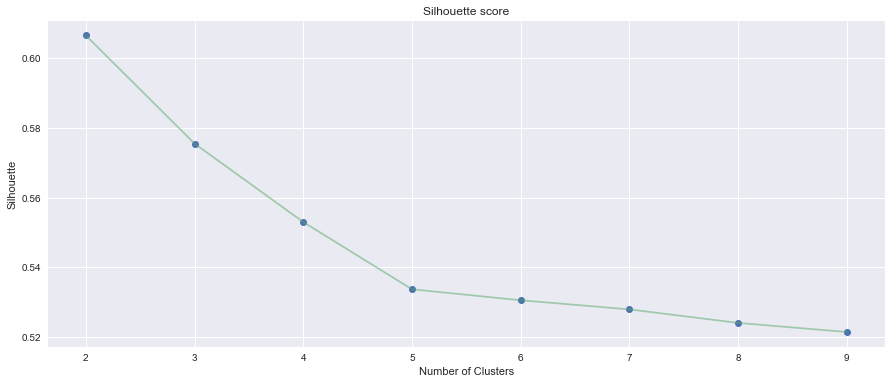

In [42]:
inertia, silhouette = k_means_inertia_silhouette(XM, k_max = 10, init = 'k-means++')

We choose k=4 due to elbow from inertia indicates 4, and in silhouette decrease not quite significant

In [43]:
k = 4
k_meansM = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_meansM.fit(XM)

KMeans(n_clusters=4, random_state=123)

In [44]:
SegmentM = k_meansM.labels_
XM.groupby(SegmentM, as_index=False).mean().sort_values(by='monetary',ignore_index=True)

monetary
0   560.341828
1  1054.557134
2  1425.534694
3  1838.757143

In [45]:
df_cust['M'] = k_meansM.predict(df_cust[['monetary']])
df_cust.head()

customer_id  recency  frequency  monetary  R  F  M
0      CS1112      216         15      1012  2  1  1
1      CS1123      264         19      1331  2  1  3
2      CS1124      228         18      1127  2  1  1
3      CS1134      264         16      1166  2  1  1
4      CS1139      266         18      1245  2  1  3

In [46]:
df_cust = cluster_order('M','monetary',df_cust,True)
df_cust.head()

customer_id  recency  frequency  monetary  R  F  M
0      CS1112      216         15      1012  2  1  1
1      CS1124      228         18      1127  2  1  1
2      CS1134      264         16      1166  2  1  1
3      CS1158      257         18      1159  2  1  1
4      CS1167      274         16      1132  2  1  1

In [47]:
df_cust.groupby(['M'])['monetary'].describe()

count         mean         std     min     25%     50%      75%     max
M                                                                          
0  1805.0   560.341828  143.247066   149.0   460.0   566.0   673.00   806.0
1  1689.0  1054.557134  122.556372   807.0   961.0  1071.0  1161.00  1238.0
2  2205.0  1425.534694  109.839721  1239.0  1331.0  1423.0  1517.00  1630.0
3  1190.0  1838.757143  175.772979  1631.0  1701.0  1791.0  1940.75  2933.0

#### Calculate Total Score from RFM Segment

In [48]:
df_cust.dtypes

customer_id    object
recency         int32
frequency       int64
monetary        int64
R               int64
F               int64
M               int64
dtype: object

In [49]:
df_cust['total_score'] = df_cust['R']+df_cust['F']+df_cust['M']
print(df_cust['total_score'].dtypes)
df_cust.groupby(['total_score'])['recency','frequency','monetary'].mean()

int64


<ipython-input-49-362b394efa50>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_cust.groupby(['total_score'])['recency','frequency','monetary'].mean()


recency  frequency     monetary
total_score                                    
0            580.773913   9.800000   461.034783
1            380.467066  11.170659   543.443114
2            286.043088  12.228007   609.919210
3            236.024666  13.210689   707.492292
4            235.302895  16.169265   997.748330
5            221.120344  17.813754  1186.399236
6            218.817888  20.053879  1391.984914
7            193.470879  21.825271  1519.017769
8            205.560784  24.835294  1787.678431
9            178.556420  27.083658  1908.490272

##### Grouping based on total score

We can see that the mean is increasing since the total_score group is increase, so we grouping based on data quartile in each variable especially monetary and frequency

In [50]:
df_cust['group'] = 'Low'
df_cust.loc[df_cust['total_score']>2,'group'] = 'Low-Mid' 
df_cust.loc[df_cust['total_score']>5,'group'] = 'Mid-High'
df_cust.loc[df_cust['total_score']>7,'group'] = 'High'
df_cust.head()

customer_id  recency  frequency  monetary  R  F  M  total_score    group
0      CS1112      216         15      1012  2  1  1            4  Low-Mid
1      CS1124      228         18      1127  2  1  1            4  Low-Mid
2      CS1134      264         16      1166  2  1  1            4  Low-Mid
3      CS1158      257         18      1159  2  1  1            4  Low-Mid
4      CS1167      274         16      1132  2  1  1            4  Low-Mid

#### Visualize the total score

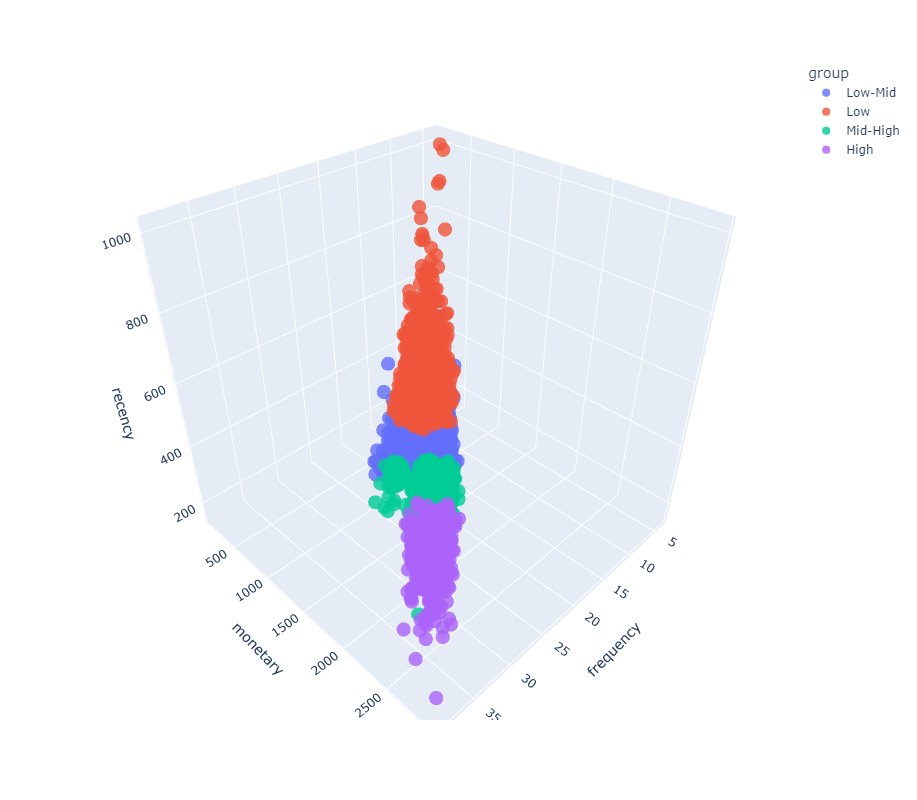

In [51]:
import plotly.express as px

df_cust['group'] = list(map(str, df_cust['group']))
fig = px.scatter_3d(df_cust, x='frequency', y='monetary', z='recency', color='group',
                   opacity = 0.8, height=800)
fig.show()

#### 2. Working with all variable

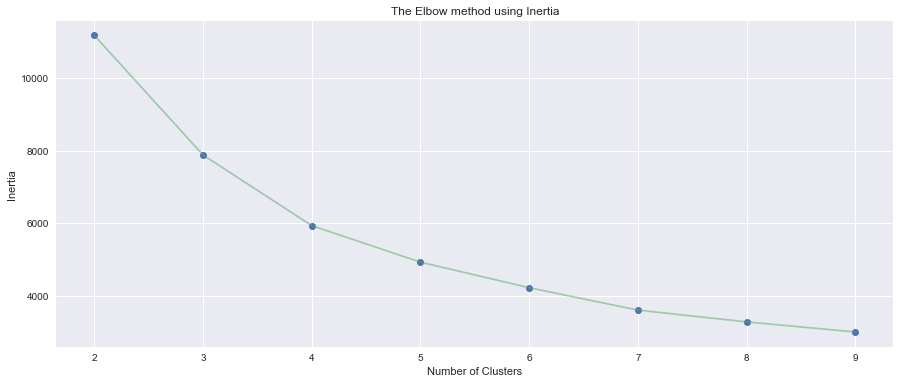

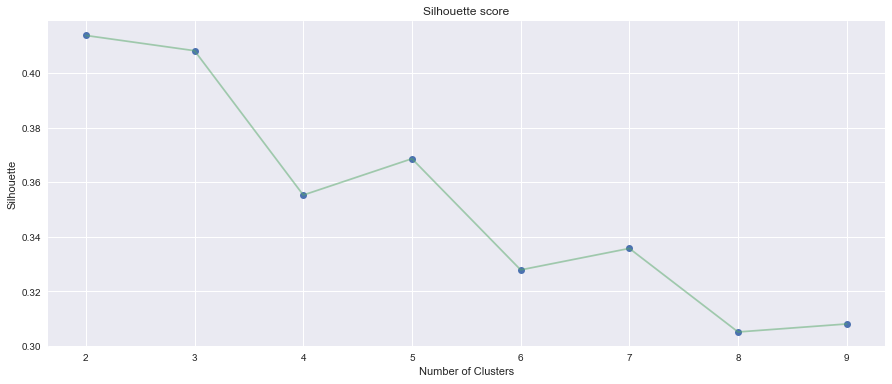

In [52]:
inertia, silhouette = k_means_inertia_silhouette(X_std, k_max = 10, init = 'k-means++')

We choose k=4 due to elbow from inertia indicates 4, despite in silhouette decrease

##### 2.a k=4

In [53]:
k = 4
k_means4 = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means4.fit(X_std)

KMeans(n_clusters=4, random_state=123)

In [54]:
Segment = k_means4.labels_
X.groupby(Segment, as_index=False).mean()

recency  frequency     monetary
0  434.691589  13.213396   754.507788
1  217.953852  18.595930  1262.949855
2  219.166667  12.746599   643.816327
3  205.563258  24.757943  1749.430965

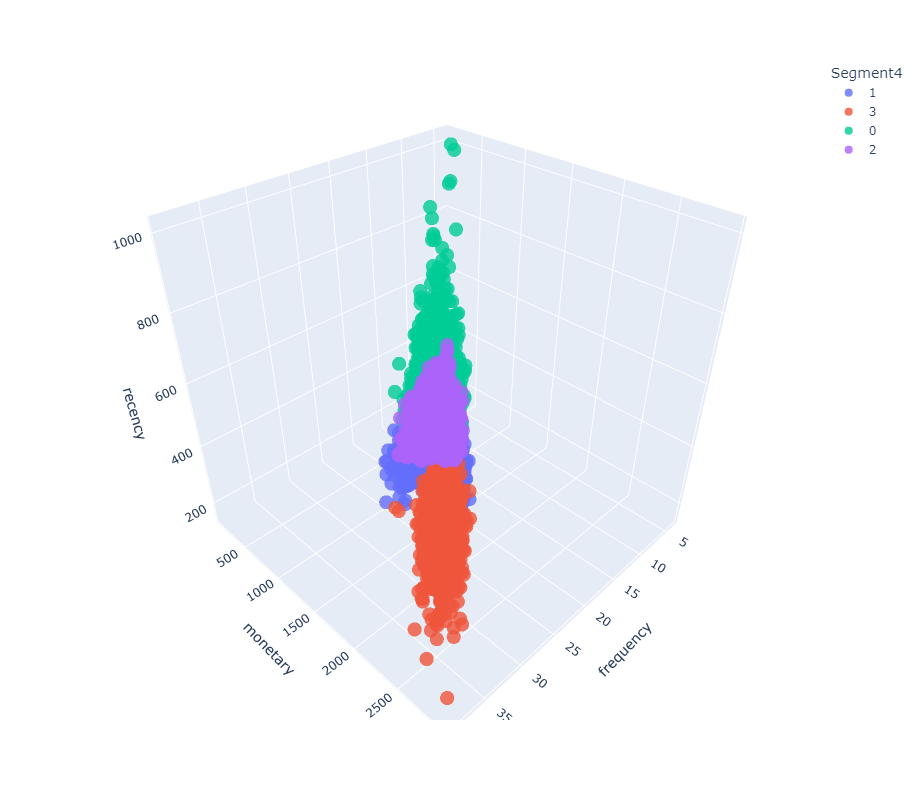

In [55]:
X['Segment4'] = list(map(str, Segment))
fig = px.scatter_3d(X, x='frequency', y='monetary', z='recency', color='Segment4',
                   opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg') 

##### 2.b. k=3

We try compare by choose k=3 due to silhouette k=3 > k=4

In [56]:
k = 3
k_means3 = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means3.fit(X_std)

KMeans(n_clusters=3, random_state=123)

In [57]:
Segment = k_means3.labels_
X.groupby(Segment, as_index=False).mean()

recency  frequency     monetary
0  415.584184  13.323980   763.491071
1  213.496069  14.462473   830.807005
2  211.110070  22.403387  1572.668279

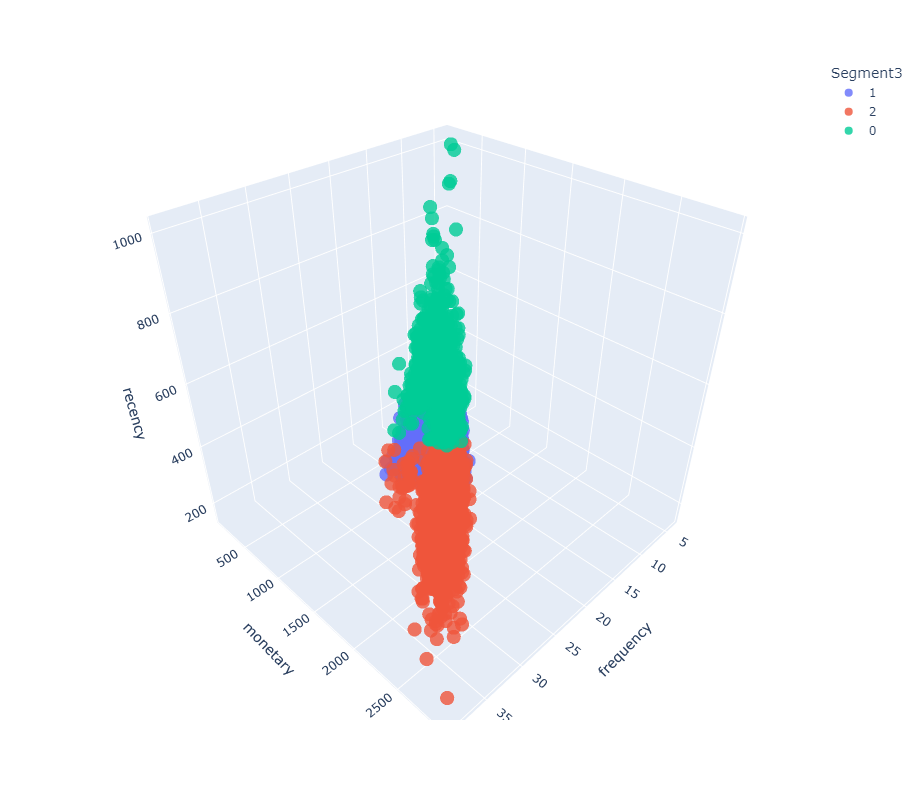

In [58]:
X['Segment3'] = list(map(str, Segment))
fig = px.scatter_3d(X, x='frequency', y='monetary', z='recency', color='Segment3',
                   opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg') 

### Conclution

1. From 3 created model, we choose model 2.a as suggestion to Marketing Team due to some reason such as :
**a.** In Model 1, we see in Mid_low Segment that there is no differentiation between customer with high monetary score with small monetary score just because small monetary score have small recency score
**b.** In Model 2.b, we can see in segment 1 that there is no separation between customer that have small frequencies and mid frequencies

2. From Model 2.a we can say that segment 3 is high potential customer, segment 1 is high-mid potential customer, segment 2 is mid-low potential customer and segment 0 is low potential customer.